<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

In [128]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.names

1. Title: 1984 United States Congressional Voting Records Database

2. Source Information:
    (a) Source:  Congressional Quarterly Almanac, 98th Congress, 
                 2nd session 1984, Volume XL: Congressional Quarterly Inc. 
                 Washington, D.C., 1985.
    (b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
    (c) Date: 27 April 1987 

3. Past Usage
   - Publications
     1. Schlimmer, J. C. (1987).  Concept acquisition through 
        representational adjustment.  Doctoral dissertation, Department of 
        Information and Computer Science, University of California, Irvine, CA.
        -- Results: about 90%-95% accuracy appears to be STAGGER's asymptote
     - Predicted attribute: party affiliation (2 classes)

4. Relevant Information:
      This data set includes votes for each of the U.S. House of
      Representatives Congressmen on the 16 key votes identified by the
      CQA.  The CQA lists nine different types of votes: voted for, paired
      

In [129]:
import pandas as pd
columns=['Party', 'handicapped_infants', 'water_project','adoption_budget','physician_fee','salvador_aid', 'religious_groups','satellite_test','aid_to_nicaraguan', 'mx_missile',
       'immigration', 'synfuels_cutback','education_spending','superfund_sue','crime','exports','export_south-africa']

df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', names= columns, na_values='?')
print(df.shape)
df.head()

(435, 17)


,Party,handicapped_infants,water_project,adoption_budget,physician_fee,salvador_aid,religious_groups,satellite_test,aid_to_nicaraguan,mx_missile,immigration,synfuels_cutback,education_spending,superfund_sue,crime,exports,export_south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [130]:
df=df.replace(['y','n'],[1,0])
#df = df.replace({'?':np.NaN, 'n':0, 'y':1})
print(df.shape)
df.head()

(435, 17)


,Party,handicapped_infants,water_project,adoption_budget,physician_fee,salvador_aid,religious_groups,satellite_test,aid_to_nicaraguan,mx_missile,immigration,synfuels_cutback,education_spending,superfund_sue,crime,exports,export_south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [131]:
df.isna().sum()

Party                    0
handicapped_infants     12
water_project           48
adoption_budget         11
physician_fee           11
salvador_aid            15
religious_groups        11
satellite_test          14
aid_to_nicaraguan       15
mx_missile              22
immigration              7
synfuels_cutback        21
education_spending      31
superfund_sue           25
crime                   17
exports                 28
export_south-africa    104
dtype: int64

In [132]:
df.describe()

,handicapped_infants,water_project,adoption_budget,physician_fee,salvador_aid,religious_groups,satellite_test,aid_to_nicaraguan,mx_missile,immigration,synfuels_cutback,education_spending,superfund_sue,crime,exports,export_south-africa
count,423.000000,387.000000,424.000000,424.000000,420.000000,424.000000,421.000000,420.00000,413.000000,428.000000,414.000000,404.000000,410.000000,418.000000,407.000000,331.000000
mean,0.442080,0.503876,0.596698,0.417453,0.504762,0.641509,0.567696,0.57619,0.501211,0.504673,0.362319,0.423267,0.509756,0.593301,0.427518,0.812689
std,0.497222,0.500632,0.491140,0.493721,0.500574,0.480124,0.495985,0.49475,0.500605,0.500563,0.481252,0.494690,0.500516,0.491806,0.495327,0.390752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#df=df.fillna(0.5)
df=df.dropna()

In [134]:
df.isna().sum()

Party                  0
handicapped_infants    0
water_project          0
adoption_budget        0
physician_fee          0
salvador_aid           0
religious_groups       0
satellite_test         0
aid_to_nicaraguan      0
mx_missile             0
immigration            0
synfuels_cutback       0
education_spending     0
superfund_sue          0
crime                  0
exports                0
export_south-africa    0
dtype: int64

In [135]:
democrat= df[df['Party']=='democrat']
print(democrat.shape)
democrat.head()

(124, 17)


,Party,handicapped_infants,water_project,adoption_budget,physician_fee,salvador_aid,religious_groups,satellite_test,aid_to_nicaraguan,mx_missile,immigration,synfuels_cutback,education_spending,superfund_sue,crime,exports,export_south-africa
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
19,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
23,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
25,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
26,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [136]:
repub= df[df['Party']=='republican']
print(repub.shape)
repub.head()

(108, 17)


,Party,handicapped_infants,water_project,adoption_budget,physician_fee,salvador_aid,religious_groups,satellite_test,aid_to_nicaraguan,mx_missile,immigration,synfuels_cutback,education_spending,superfund_sue,crime,exports,export_south-africa
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
28,republican,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
30,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
33,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
35,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [137]:
df.apply(pd.Series.value_counts).T

,0.0,1.0,democrat,republican
Party,NaN,NaN,124.0,108.0
handicapped_infants,136.0,96.0,NaN,NaN
water_project,125.0,107.0,NaN,NaN
adoption_budget,109.0,123.0,NaN,NaN
physician_fee,119.0,113.0,NaN,NaN
salvador_aid,104.0,128.0,NaN,NaN
religious_groups,83.0,149.0,NaN,NaN
satellite_test,108.0,124.0,NaN,NaN
aid_to_nicaraguan,113.0,119.0,NaN,NaN
mx_missile,119.0,113.0,NaN,NaN


## Democrat Support

In [138]:
print('democrat support: ', democrat['handicapped_infants'].mean())
print('republican support: ',repub['handicapped_infants'].mean())

democrat support:  0.5887096774193549
republican support:  0.21296296296296297


In [139]:
# calculation of tstat, pvalue
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel
import numpy as np
tstat,pvalue= ttest_ind(democrat['handicapped_infants'], repub['handicapped_infants'])
print(tstat)
print(pvalue)

6.240907554031057
2.0722024876891192e-09


Null hypothesis - No difference between parties, they supported the bill equally( the mean of democrat support== the mean of the republican support)

Alternative Hypothesis- the means are different(not the same level of support)

T-statistic goes up and pvalue (p<0.01) goes down
Given the result of positive  t-statistic, i would reject the null hypothesis that there is same level of support for this bill among democrats and republican


## Republican support

In [140]:
repub.apply(pd.Series.value_counts).T

,0.0,1.0,republican
Party,NaN,NaN,108.0
handicapped_infants,85.0,23.0,NaN
water_project,57.0,51.0,NaN
adoption_budget,91.0,17.0,NaN
physician_fee,1.0,107.0,NaN
salvador_aid,5.0,103.0,NaN
religious_groups,14.0,94.0,NaN
satellite_test,79.0,29.0,NaN
aid_to_nicaraguan,92.0,16.0,NaN
mx_missile,93.0,15.0,NaN


In [141]:
print('Democrat support: ', democrat['crime'].mean())
print('Republican support: ', repub['crime'].mean())

Democrat support:  0.3467741935483871
Republican support:  0.9814814814814815


In [142]:
tstat, pvalue= ttest_ind(repub['crime'], democrat['crime'])
print(tstat)
print(pvalue)

13.34079793707258
1.8791646941359472e-30


Null Hypothesis- Both parties supported the bill equally(mean of democrat=mean of the republican )

Alternative Hypothesis-  republican supported more than the democrat

T-statistic goes up and pvalue <0.01, Given the result of positive tstatistic i would reject the null hypothesis

## NO significant support

In [143]:
print('democrat support: ', democrat['water_project'].mean())
print('Republican support: ', repub['water_project'].mean())


democrat support:  0.45161290322580644
Republican support:  0.4722222222222222


In [144]:
tstat, pvalue=ttest_ind(democrat['water_project'], repub['water_project'])
print(tstat)
print(pvalue)

-0.3128208943045492
0.7547001979801332


 Null Hypothesis- Both parties equally supported the project
 
 Alternative Hypothesis - Not the same level of support
 
 Given the result of pvalue > 0.5 and i would fail to reject the null hypothesis

In [0]:
def hypothesis(p_value):
  if p_value <=0.5:
    return ('Reject Null Hypothesis')
  else:
    return ('Failed to reject Null Hypothesis')
  

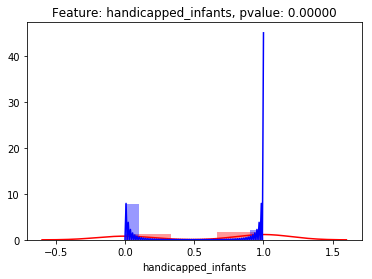

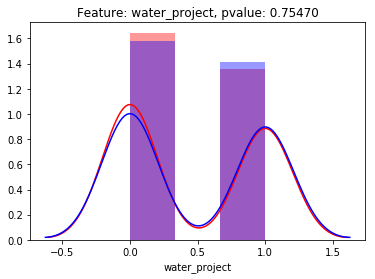

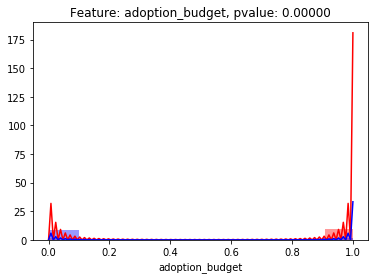

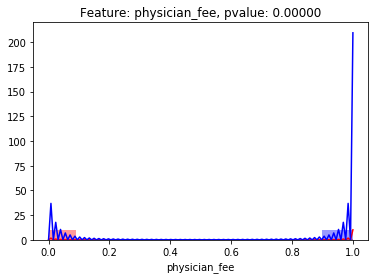

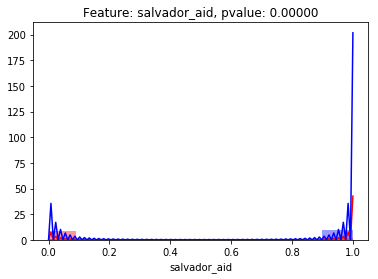

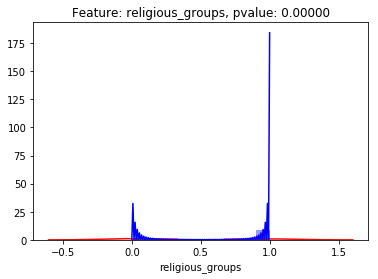

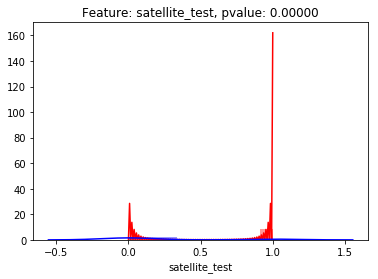

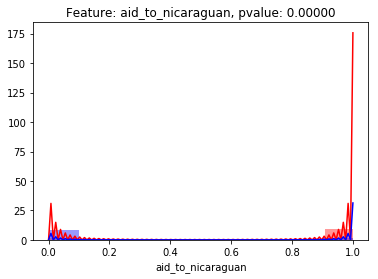

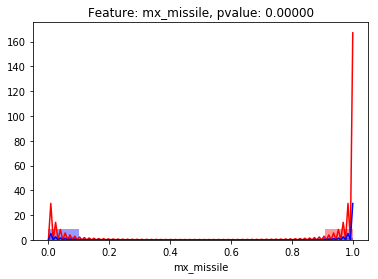

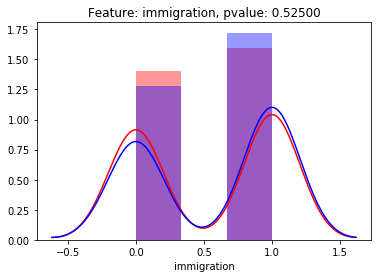

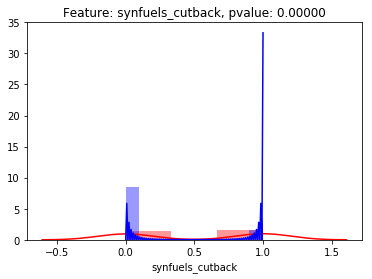

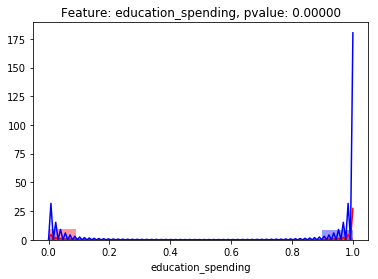

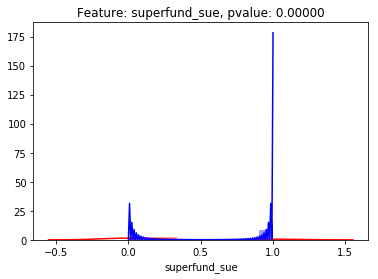

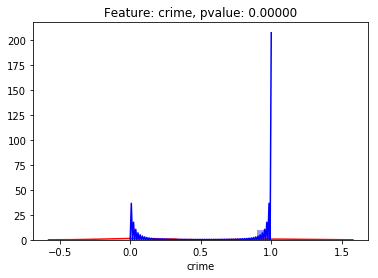

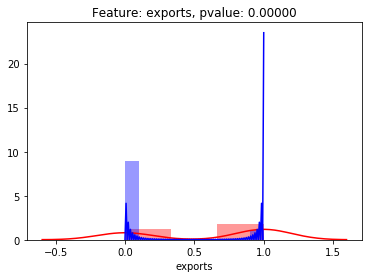

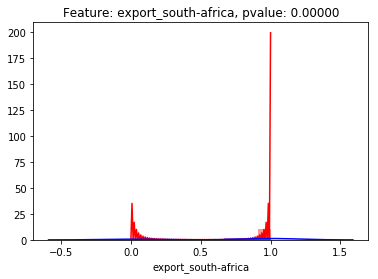

<Figure size 432x288 with 0 Axes>

In [146]:
# second part of the assignment
import seaborn as sns
from matplotlib import style
import numpy as np  
for vote in df.columns[1:]:
  group1= df[df['Party']=='democrat'][vote]
  group2= df[df['Party']=='republican'][vote]
  
  # run tstat, pvalue
  tstat,pvalue= ttest_ind(group1,group2)
  #Plot distribution
  sns.distplot(group1, color='r')
  sns.distplot(group2, color='b')
   
  # Plot title
  # hypothesis = hypothesis(pvalue)
   #plt.title(f'Feature: {vote}, pvalue: {pvalue:.5f} \n {hypothesis}');
  plt.title(f'Feature: {vote}, pvalue: {pvalue:.5f}');
  plt.figure()
  

##Graph analysis of Null hypothesis

1)find an issue that democrats support more than republicans with p < 0.01

 - Answer-handicapped-infants, budget, anti-satellite-ban, aid-to-contras, mx-missile, synfuels, duty-free, south-africa
 
2)find an issue that republicans support more than democrats with p < 0.01

- Answer: physician-fee-freeze, el-salvador-aid, religious-groups, immigration, education, right-to-sue, crime

3)find an issue where the difference between republicans and democrats has p > 0.1

(i.e. there may not be much of a difference)

 - Answer: water-project


In [147]:
#percentage of democrat supported the bill
democrat['handicapped_infants'].mean()

0.5887096774193549

In [148]:
democrat['handicapped_infants'].value_counts()
# 9 people abstrain from voting

1.0    73
0.0    51
Name: handicapped_infants, dtype: int64